



Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA # Import PCA
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
#from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Creating a Dataframe

In [3]:
df=pd.read_csv('/content/drive/MyDrive/projectdataset.csv')

Getting info about Database

In [4]:
df.head()

,Gender,Country,Occupation,SelfEmployed,FamilyHistory,Treatment,DaysIndoors,HabitsChange,MentalHealthHistory,IncreasingStress,MoodSwings,SocialWeakness,CopingStruggles,WorkInterest,SocialWeakness.1,MentalHealthInterview,CareOptions
0,Female,UK,Others,No,Yes,No,15-30 days,No,Yes,Yes,High,No,Yes,Maybe,No,No,No
1,Female,USA,Housewife,No,Yes,No,15-30 days,Maybe,Maybe,Yes,High,Maybe,Yes,Maybe,Maybe,No,Not sure
2,Female,Canada,Others,No,No,Yes,More than 2 months,Maybe,No,No,Medium,No,No,No,No,No,Not sure
3,Female,Canada,Corporate,No,Yes,Yes,Go out Every day,No,Maybe,No,Medium,No,No,Maybe,No,No,Not sure
4,Female,UK,Corporate,No,No,Yes,More than 2 months,Yes,No,Maybe,Medium,Maybe,No,Maybe,Maybe,No,Not sure


In [5]:
print(df.shape)

(261328, 17)


Check missing values and data types

In [6]:
print("\nMissing values per column:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)


Missing values per column:
 Gender                      0
Country                     0
Occupation                  0
SelfEmployed             4356
FamilyHistory               0
Treatment                   0
DaysIndoors                 0
HabitsChange                0
MentalHealthHistory         0
IncreasingStress            0
MoodSwings                  0
SocialWeakness              0
CopingStruggles             0
WorkInterest                0
SocialWeakness.1            0
MentalHealthInterview       0
CareOptions                 0
dtype: int64

Data types:
 Gender                   object
Country                  object
Occupation               object
SelfEmployed             object
FamilyHistory            object
Treatment                object
DaysIndoors              object
HabitsChange             object
MentalHealthHistory      object
IncreasingStress         object
MoodSwings               object
SocialWeakness           object
CopingStruggles          object
WorkInterest      

Drop unnecessary and duplicate columns

In [7]:
df_clean = df.drop(columns=["CareOptions", "MentalHealthInterview", "SocialWeakness.1"], errors="ignore")
df_clean = df_clean[df_clean["SocialWeakness"].str.lower() != "maybe"]
df_clean.reset_index(drop=True, inplace=True)

Confirm result

In [8]:
print(f"After dropping columns: {df_clean.shape}")
print("Remaining columns:", df_clean.columns.tolist())

After dropping columns: (168057, 14)
Remaining columns: ['Gender', 'Country', 'Occupation', 'SelfEmployed', 'FamilyHistory', 'Treatment', 'DaysIndoors', 'HabitsChange', 'MentalHealthHistory', 'IncreasingStress', 'MoodSwings', 'SocialWeakness', 'CopingStruggles', 'WorkInterest']


Check unique target values

In [9]:
print("\nTarget column ('SocialWeakness') unique values:")
print(df_clean["SocialWeakness"].value_counts())


Target column ('SocialWeakness') unique values:
SocialWeakness
No     87946
Yes    80111
Name: count, dtype: int64


Quick visual exploration

In [10]:
sns.set(style="whitegrid")

Target distribution

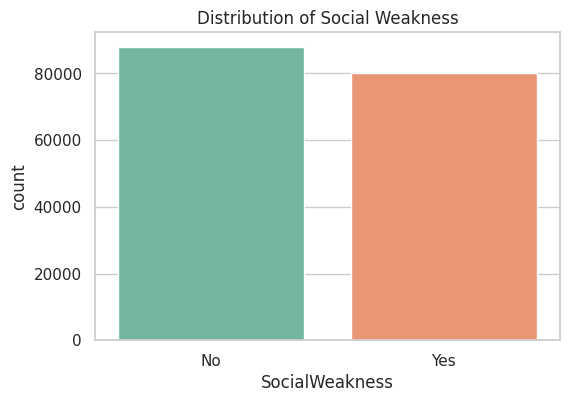

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x="SocialWeakness", data=df_clean, palette="Set2")
plt.title("Distribution of Social Weakness")
plt.show()

Gender distribution

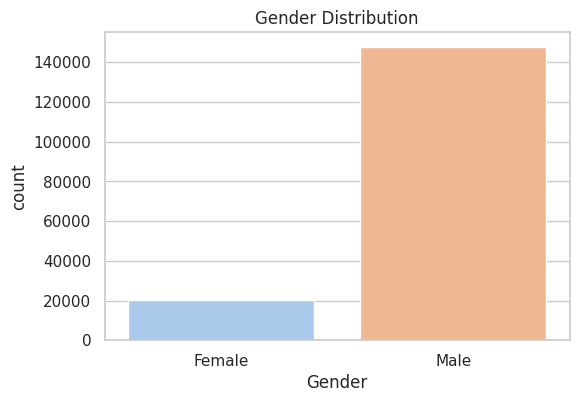

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x="Gender", data=df_clean, palette="pastel")
plt.title("Gender Distribution")
plt.show()

Social Weakness by Gender

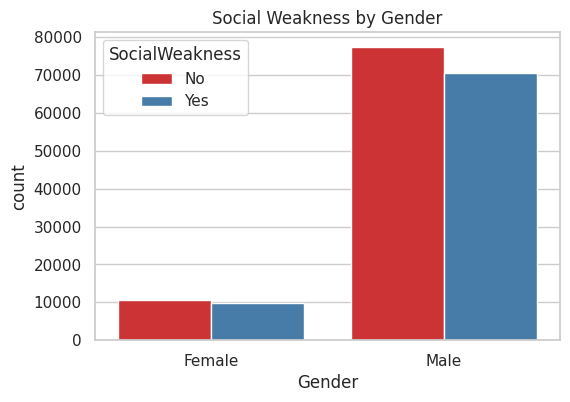

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x="Gender", hue="SocialWeakness", data=df_clean, palette="Set1")
plt.title("Social Weakness by Gender")
plt.show()

Days Indoors

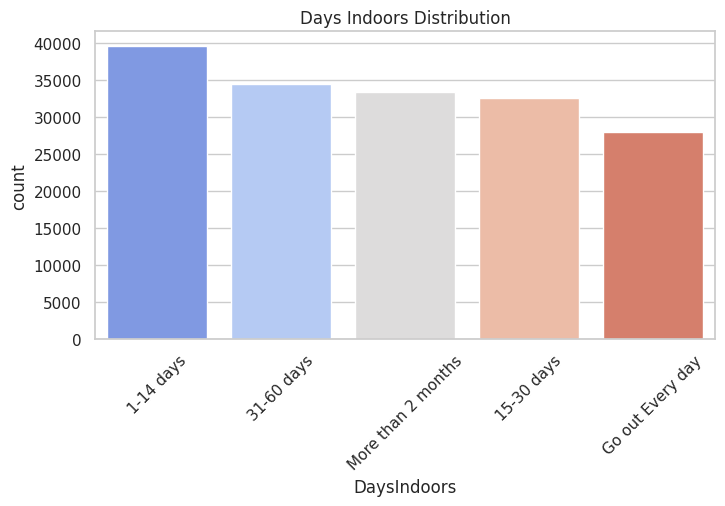

In [14]:
plt.figure(figsize=(8,4))
sns.countplot(x="DaysIndoors", data=df_clean,
              order=df_clean["DaysIndoors"].value_counts().index, palette="coolwarm")
plt.title("Days Indoors Distribution")
plt.xticks(rotation=45)
plt.show()


Days Indoors vs Social Weakness

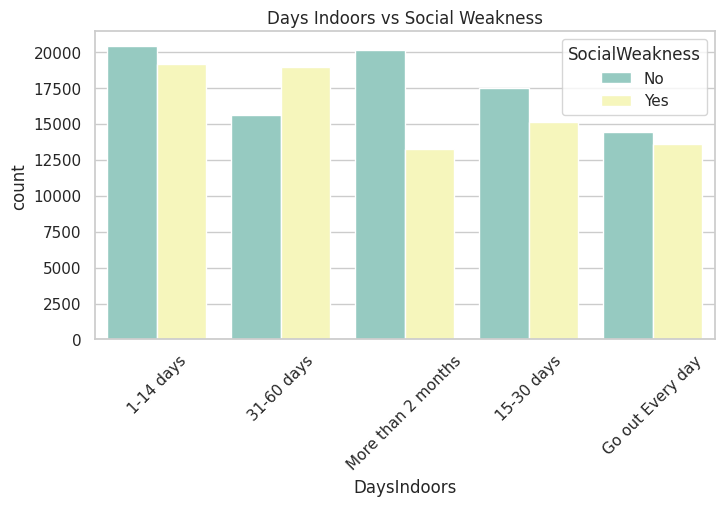

In [15]:
plt.figure(figsize=(8,4))
sns.countplot(x="DaysIndoors", hue="SocialWeakness", data=df_clean,
              order=df_clean["DaysIndoors"].value_counts().index, palette="Set3")
plt.title("Days Indoors vs Social Weakness")
plt.xticks(rotation=45)
plt.show()

In [16]:
sns.set(style="whitegrid")
features = ["FamilyHistory", "MentalHealthHistory", "Treatment",
            "IncreasingStress", "MoodSwings", "CopingStruggles"]

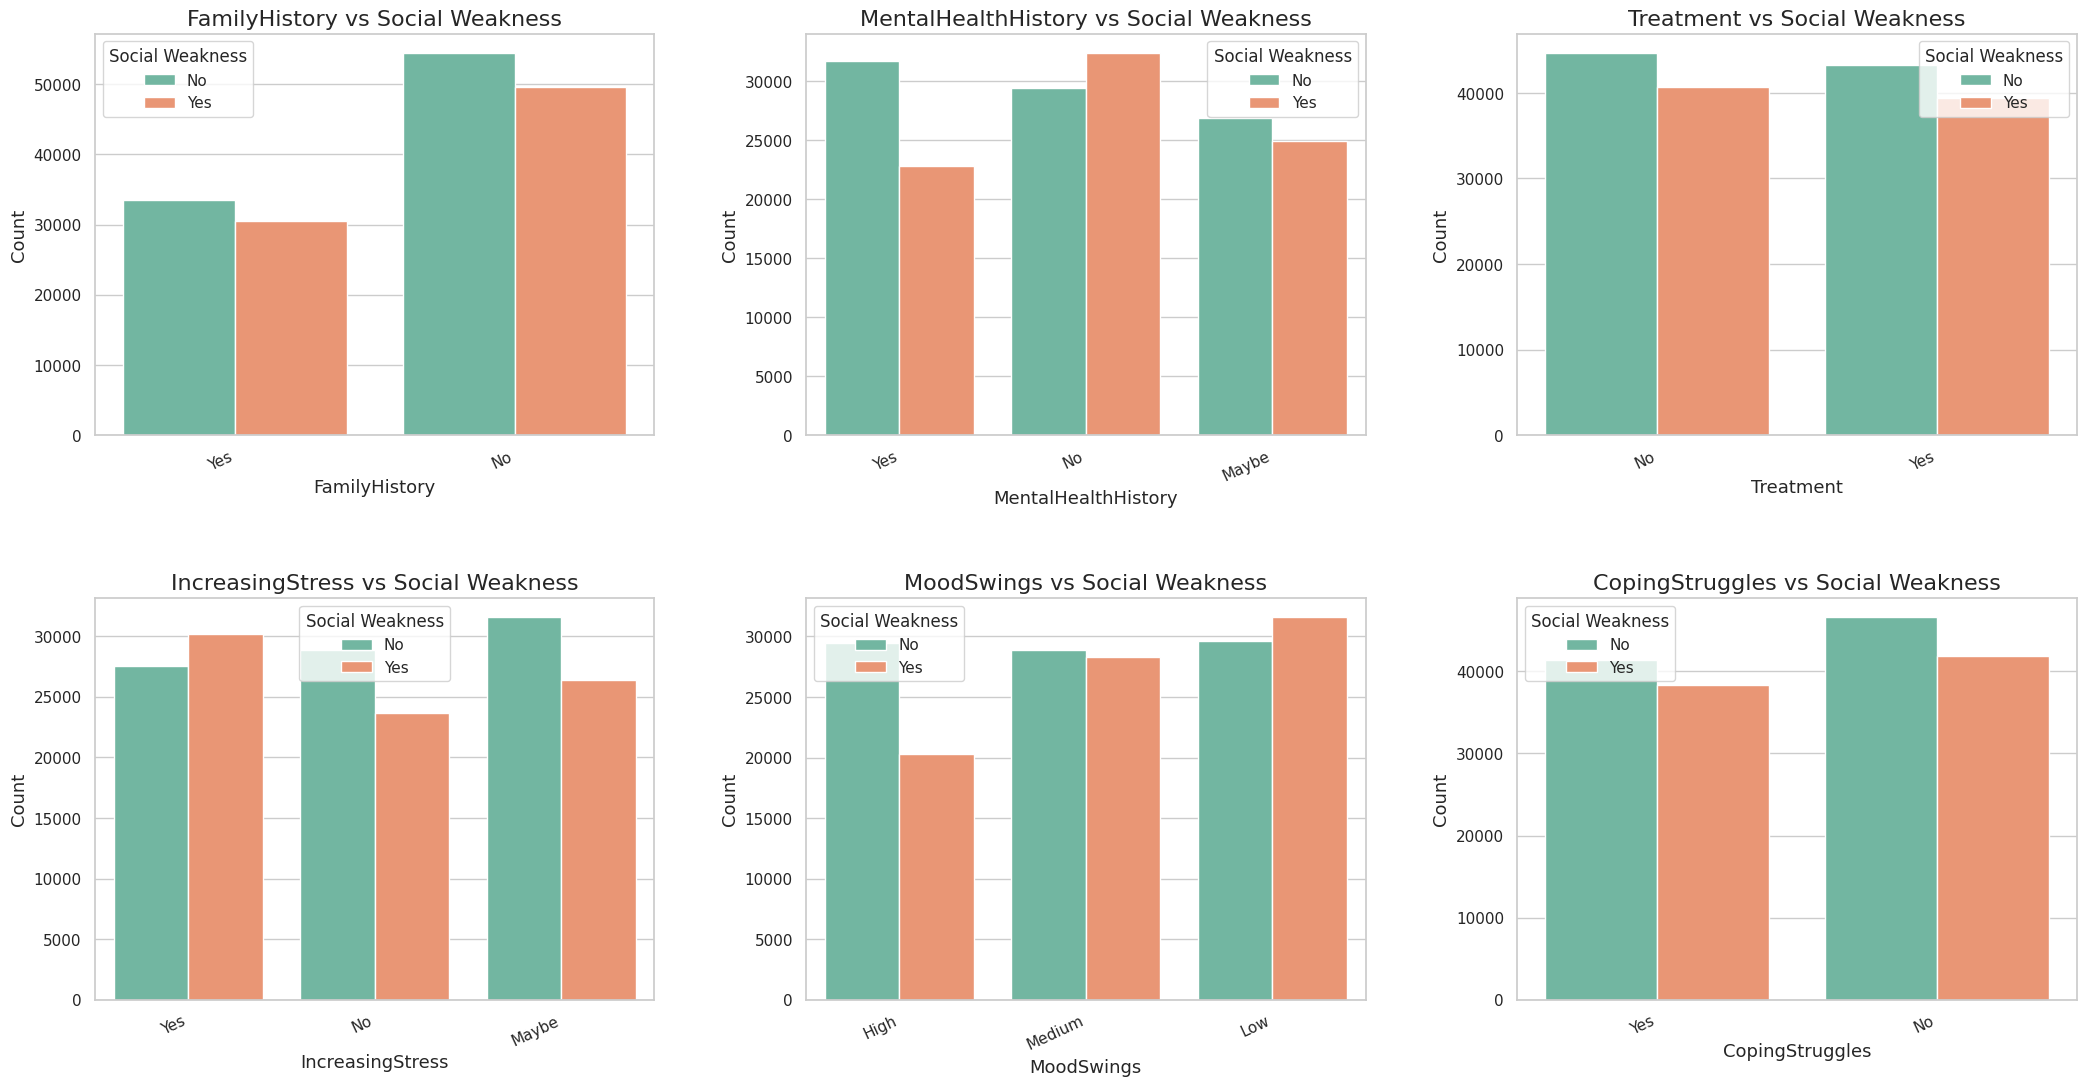

In [17]:
plt.figure(figsize=(22, 12))

for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=col, hue="SocialWeakness", data=df_clean, palette="Set2")
    plt.title(f"{col} vs Social Weakness", fontsize=16)
    plt.xlabel(col, fontsize=13)
    plt.ylabel("Count", fontsize=13)
    plt.xticks(rotation=25, ha='right')
    plt.legend(title="Social Weakness", fontsize=11, title_fontsize=12)

plt.tight_layout(pad=4.0)
plt.show()

Clean and Normalize Data

1️⃣ Convert all text to lowercase and remove spaces

In [18]:
df_clean = df_clean.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

2️⃣ Fill missing values in 'selfemployed' with mode

In [19]:
mode_selfemp = df_clean['SelfEmployed'].mode()[0]
df_clean['SelfEmployed'].fillna(mode_selfemp, inplace=True)

3️⃣ Check remaining missing value

In [20]:
print("Remaining missing values:\n", df_clean.isnull().sum())

Remaining missing values:
 Gender                 0
Country                0
Occupation             0
SelfEmployed           0
FamilyHistory          0
Treatment              0
DaysIndoors            0
HabitsChange           0
MentalHealthHistory    0
IncreasingStress       0
MoodSwings             0
SocialWeakness         0
CopingStruggles        0
WorkInterest           0
dtype: int64


4️⃣ Verify normalization for key feature

In [21]:
for col in ['Gender', 'FamilyHistory', 'Treatment', 'SocialWeakness']:
    print(f"\nUnique values in {col}: {df_clean[col].unique()}")


Unique values in Gender: ['female' 'male']

Unique values in FamilyHistory: ['yes' 'no']

Unique values in Treatment: ['no' 'yes']

Unique values in SocialWeakness: ['no' 'yes']


5️⃣ Display a few cleaned rows

In [22]:
print(df_clean.head(10).to_markdown())

|    | Gender   | Country     | Occupation   | SelfEmployed   | FamilyHistory   | Treatment   | DaysIndoors        | HabitsChange   | MentalHealthHistory   | IncreasingStress   | MoodSwings   | SocialWeakness   | CopingStruggles   | WorkInterest   |
|---:|:---------|:------------|:-------------|:---------------|:----------------|:------------|:-------------------|:---------------|:----------------------|:-------------------|:-------------|:-----------------|:------------------|:---------------|
|  0 | female   | uk          | others       | no             | yes             | no          | 15-30 days         | no             | yes                   | yes                | high         | no               | yes               | maybe          |
|  1 | female   | canada      | others       | no             | no              | yes         | more than 2 months | maybe          | no                    | no                 | medium       | no               | no                | no             |


Correlation heatmap and one-hot encoding

1️⃣ Encode categorical features temporarily (label encoding for correlation visualization)

In [23]:
df_encoded = df_clean.copy()
le = LabelEncoder()
for col in df_encoded.columns:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))


2️⃣ Plot correlation heatmap

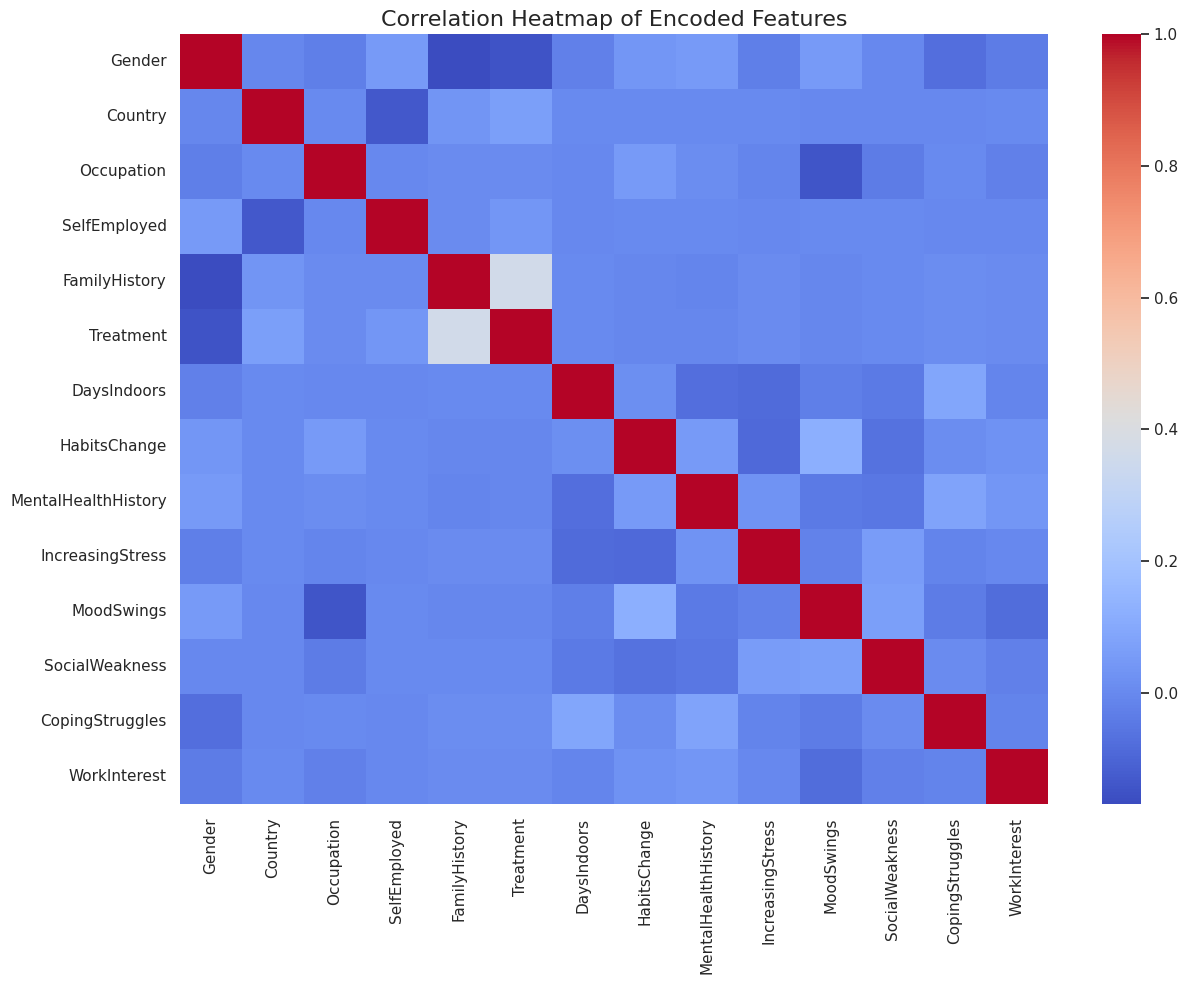

In [24]:
plt.figure(figsize=(14,10))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Encoded Features", fontsize=16)
plt.show()

3️⃣ Now prepare data for modeling

In [25]:
binary_df = df_clean[df_clean["SocialWeakness"].isin(["yes", "no"])].copy()
_, binary_df = train_test_split(
    binary_df, test_size=0.3, stratify=binary_df["SocialWeakness"], random_state=42)
print("✅ After stratified sampling:")
print(binary_df["SocialWeakness"].value_counts())
print("Sample size:", binary_df.shape)

✅ After stratified sampling:
SocialWeakness
no     26384
yes    24034
Name: count, dtype: int64
Sample size: (50418, 14)


In [26]:
X_binary = binary_df.drop(columns=["SocialWeakness"])
y_binary = binary_df["SocialWeakness"].map({"no": 0, "yes": 1})

4️⃣ One-Hot Encode the categorical predictors

In [27]:
X_binary_encoded = pd.get_dummies(X_binary, drop_first=True).astype(int)

5️⃣ Encode target as numeric (Yes=1, No=0, Maybe=2 for now)

In [28]:
#y_encoded = y.map({"no": 0, "yes": 1, "maybe": 2})

6️⃣ Confirm shapes

In [29]:
#print(f"Feature matrix shape: {X_encoded.shape}")
#print(f"Target vector shape: {y_encoded.shape}")

Correlation Analysis

🔹 Highly Correlated Features (r > 0.8):
| Feature 1   | Feature 2   | Correlation   |
|-------------|-------------|---------------|

🔸 Moderately Correlated Features (0.5 < r ≤ 0.8):
| Feature 1               | Feature 2              |   Correlation |
|:------------------------|:-----------------------|--------------:|
| Country_usa             | Country_uk             |      0.564787 |
| MoodSwings_medium       | MoodSwings_low         |      0.542742 |
| MentalHealthHistory_yes | MentalHealthHistory_no |      0.526545 |
| HabitsChange_yes        | HabitsChange_no        |      0.522091 |


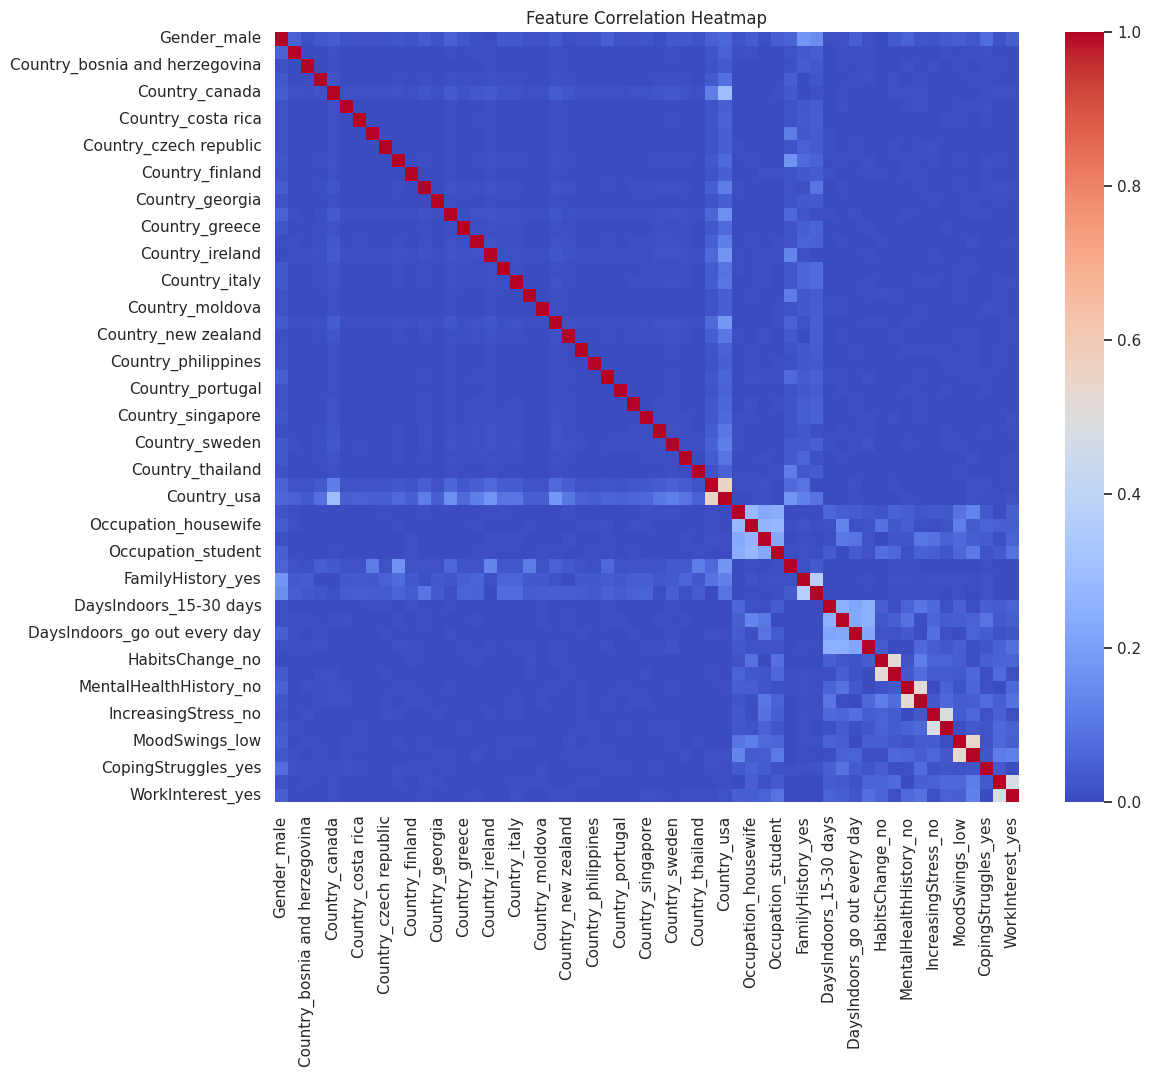

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_binary_encoded.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr = [(col, row, upper.loc[row, col])
             for col in upper.columns
             for row in upper.index
             if upper.loc[row, col] > 0.8]

moderate_corr = [(col, row, upper.loc[row, col])
                 for col in upper.columns
                 for row in upper.index
                 if 0.5 < upper.loc[row, col] <= 0.8]

high_corr_df = pd.DataFrame(high_corr, columns=["Feature 1", "Feature 2", "Correlation"]).sort_values(by="Correlation", ascending=False)
moderate_corr_df = pd.DataFrame(moderate_corr, columns=["Feature 1", "Feature 2", "Correlation"]).sort_values(by="Correlation", ascending=False)

print("🔹 Highly Correlated Features (r > 0.8):")
print(high_corr_df.to_markdown(index=False))

print("\n🔸 Moderately Correlated Features (0.5 < r ≤ 0.8):")
print(moderate_corr_df.head(15).to_markdown(index=False))

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap="coolwarm", vmax=1.0, vmin=0.0)
plt.title("Feature Correlation Heatmap")
plt.show()


7️⃣ Preview of encoded dataset

In [30]:
print("\n✅ Encoded Feature Sample:")
print(X_binary_encoded.head(10).to_markdown())


✅ Encoded Feature Sample:
|        |   Gender_male |   Country_belgium |   Country_bosnia and herzegovina |   Country_brazil |   Country_canada |   Country_colombia |   Country_costa rica |   Country_croatia |   Country_czech republic |   Country_denmark |   Country_finland |   Country_france |   Country_georgia |   Country_germany |   Country_greece |   Country_india |   Country_ireland |   Country_israel |   Country_italy |   Country_mexico |   Country_moldova |   Country_netherlands |   Country_new zealand |   Country_nigeria |   Country_philippines |   Country_poland |   Country_portugal |   Country_russia |   Country_singapore |   Country_south africa |   Country_sweden |   Country_switzerland |   Country_thailand |   Country_uk |   Country_usa |   Occupation_corporate |   Occupation_housewife |   Occupation_others |   Occupation_student |   SelfEmployed_yes |   FamilyHistory_yes |   Treatment_yes |   DaysIndoors_15-30 days |   DaysIndoors_31-60 days |   DaysIndoors_go out every 

🧠 Interpreting the Correlation Heatmap

Your heatmap shows how strongly features relate numerically after temporary encoding.
Here’s what to look for and what it likely means in your dataset:

🔹 1. Diagonal Line of 1.0

Every feature correlates perfectly with itself — that’s the bright diagonal line.

Ignore it — it’s just a sanity check that encoding worked properly.

🔹 2. Moderate Correlations (~0.4–0.6)

You might notice features like:

Correlated Features	Interpretation
increasingstress ↔ moodswings	As stress increases, mood swings tend to become more frequent — this is a psychologically consistent link.
copingstruggles ↔ moodswings	People with poor coping ability tend to have mood instability.
mentalhealthhistory ↔ familyhistory	Having family history of mental issues often links to personal mental health issues.
treatment ↔ mentalhealthhistory	People with past treatment likely have known mental health history.

These are expected correlations, so they confirm the data quality.

🔹 3. High Correlations (>0.7)

If any pairs show very strong correlation (for example):

increasingstress and copingstruggles (if >0.8)

moodswings and increasingstress

That suggests multicollinearity — features are too similar in behavior.
➡️ We can handle this later using PCA (Principal Component Analysis) or by dropping redundant columns.

🔹 4. Low Correlations (<0.3) with Target

If socialweakness (after encoding) has weak correlations with many features — don’t worry:

Low pairwise correlation doesn’t mean the feature is useless.

Nonlinear models (like Random Forest, Gradient Boosting) can still find complex patterns that linear correlation misses.

🔹 5. What You’ll Likely See

You’ll probably observe clusters:

Social/behavioral cluster: daysindoors, habitschage, workinterest, copingstruggles

Biological/mental health cluster: familyhistory, mentalhealthhistory, treatment, moodswings

Target (socialweakness) showing mild correlation with both clusters — indicating it’s influenced by both behavioral and mental health factors.

⚡ In summary:

✅ Strong related pairs = possible multicollinearity → fix later with PCA
✅ Moderate related pairs = good psychological consistency
✅ Weak target correlations = normal; nonlinear ML models will handle them

Apply SMOTE and feature scaling

1️⃣ Split into train and test sets

In [31]:
#X_train, X_test, y_train, y_test = train_test_split(
#    X_encoded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
#)
#print("Before SMOTE:")
#print(y_train.value_counts())
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_binary_encoded, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

2️⃣ Apply SMOTE (Synthetic Minority Oversampling Technique)

In [32]:
#sm = SMOTE(random_state=42)
#X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("\nAfter SMOTE:")
print(y_train_res.value_counts())



After SMOTE:
SocialWeakness
1    18468
0    18468
Name: count, dtype: int64


3️⃣ Feature scaling (StandardScaler)

In [33]:
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train_res)
#X_test_scaled = scaler.transform(X_test)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

4️⃣ Convert back to DataFrame for reference

In [34]:
#X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_encoded.columns)
#X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_encoded.columns)

5️⃣ Sanity check

In [35]:
#print(f"\nTrain shape after SMOTE & scaling: {X_train_scaled.shape}")
#print(f"Test shape: {X_test_scaled.shape}")
print("✅ Target distribution after filtering & SMOTE:")
print(y_train_res.value_counts())

print(f"\nTraining shape: {X_train_scaled.shape}")
print(f"Testing shape:  {X_test_scaled.shape}")

✅ Target distribution after filtering & SMOTE:
SocialWeakness
1    18468
0    18468
Name: count, dtype: int64

Training shape: (36936, 57)
Testing shape:  (15126, 57)


💬 Explanation
Step	Description

1️⃣ Split	Divides the dataset into 70% training and 30% testing (with class stratification to keep class ratios consistent).

2️⃣ SMOTE	Generates synthetic samples for minority classes to balance “yes/no/maybe” responses in the target. Prevents bias toward the majority class.

3️⃣ Scaling	Standardizes all features (mean = 0, std = 1) to help algorithms like SVM and Logistic Regression converge faster.

4️⃣ Conversion	Keeps column names intact after scaling.

5️⃣ Sanity check	Verifies balanced class distribution and dataset shapes.

PCA (Principal Component Analysis)

1️⃣ Initialize PCA (keep enough components to explain most variance)

In [36]:
pca = PCA(n_components=0.95, random_state=42)  # keep 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

2️⃣ Check how many components were kept

In [37]:
print(f"Number of PCA components that explain 95% variance: {pca.n_components_}")

Number of PCA components that explain 95% variance: 49


3️⃣ Plot explained variance ratio

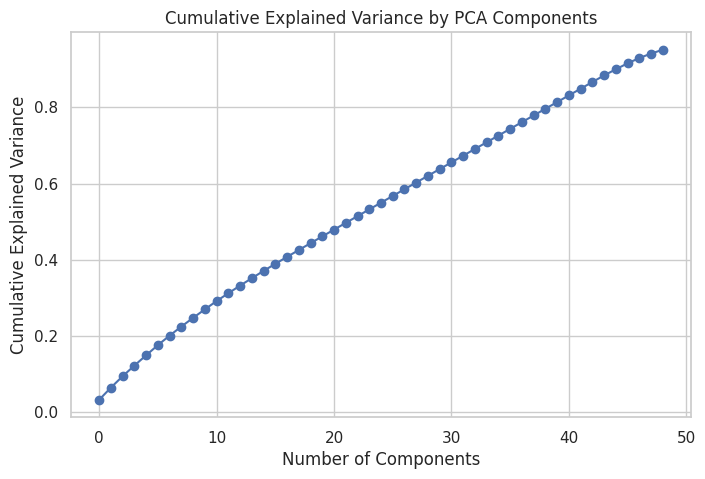

In [38]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

4️⃣ Visualize first two principal components

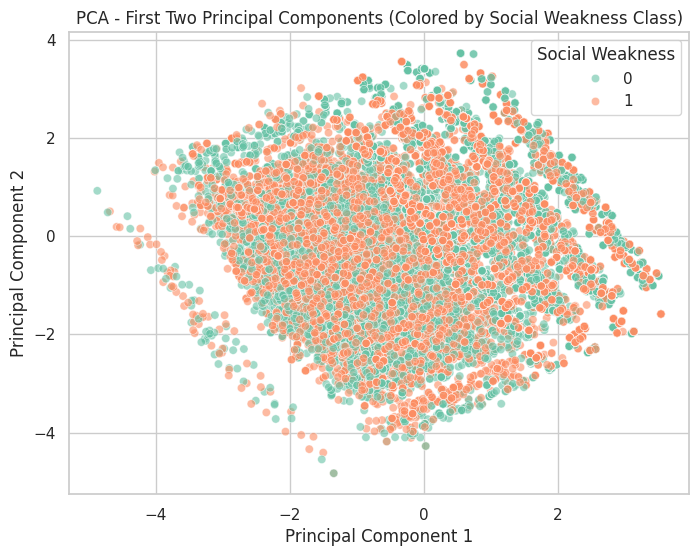

In [39]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train_res, palette='Set2', alpha=0.6)
plt.title("PCA - First Two Principal Components (Colored by Social Weakness Class)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Social Weakness")
plt.show()

💬 Explanation
Step	Description

1️⃣ PCA Initialization	We set n_components=0.95 to keep enough components to explain 95% of the dataset’s variance.

2️⃣ Component Count	Displays how many features remain after PCA. Often drops dimensionality from hundreds (after one-hot encoding) to a few dozen.

3️⃣ Explained Variance Plot	Helps visualize how many components capture most of the information.

4️⃣ PCA Scatter Plot	Visualizes samples in 2D using the first two principal components. Color-coded by SocialWeakness class — good for spotting class separation.

Model training and comparison

1️⃣ Initialize models

2️⃣ Train and evaluate

LogisticRegression

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_pca, y_train_res)
y_pred_lr = log_reg.predict(X_test_pca)

print("🔹 Logistic Regression Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_lr, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_lr, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

🔹 Logistic Regression Performance
Accuracy: 0.5590374190136189
Precision: 0.5599869883941808
Recall: 0.5590374190136189
F1 Score: 0.5592745013107797

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.56      0.57      7916
           1       0.54      0.56      0.55      7210

    accuracy                           0.56     15126
   macro avg       0.56      0.56      0.56     15126
weighted avg       0.56      0.56      0.56     15126



SVM

In [41]:
from sklearn.svm import SVC

svm_model = SVC(kernel="rbf", random_state=42)
svm_model.fit(X_train_pca, y_train_res)
y_pred_svm = svm_model.predict(X_test_pca)

print("🔹 Support Vector Machine Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_svm, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

🔹 Support Vector Machine Performance
Accuracy: 0.8301599894221869
Precision: 0.8301128371267047
Recall: 0.8301599894221869
F1 Score: 0.8300993123423707

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      7916
           1       0.83      0.81      0.82      7210

    accuracy                           0.83     15126
   macro avg       0.83      0.83      0.83     15126
weighted avg       0.83      0.83      0.83     15126



RandomForestClassifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_pca, y_train_res)
y_pred_rf = rf_model.predict(X_test_pca)

print("🔹 Random Forest Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

🔹 Random Forest Performance
Accuracy: 0.9541187359513421
Precision: 0.9546084494189272
Recall: 0.9541187359513421
F1 Score: 0.9540666725950588

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      7916
           1       0.97      0.93      0.95      7210

    accuracy                           0.95     15126
   macro avg       0.96      0.95      0.95     15126
weighted avg       0.95      0.95      0.95     15126



GradientBoostingClassifier

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, max_depth=8, random_state=42)
gb_model.fit(X_train_pca, y_train_res)
y_pred_gb = gb_model.predict(X_test_pca)

print("🔹 Gradient Boosting Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Precision:", precision_score(y_test, y_pred_gb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_gb, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_gb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))

🔹 Gradient Boosting Performance
Accuracy: 0.9760015866719556
Precision: 0.9760914537941368
Recall: 0.9760015866719556
F1 Score: 0.9759918508690465

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      7916
           1       0.98      0.97      0.97      7210

    accuracy                           0.98     15126
   macro avg       0.98      0.98      0.98     15126
weighted avg       0.98      0.98      0.98     15126




✅ Model Comparison Table:

| Model                  |   Accuracy |   Precision |   Recall |   F1 Score |
|:-----------------------|-----------:|------------:|---------:|-----------:|
| Gradient Boosting      |   0.976002 |    0.982387 | 0.96699  |   0.974628 |
| Random Forest          |   0.954119 |    0.969182 | 0.933426 |   0.950968 |
| Support Vector Machine |   0.83016  |    0.826417 | 0.81484  |   0.820588 |
| Logistic Regression    |   0.559037 |    0.535895 | 0.559085 |   0.547244 |


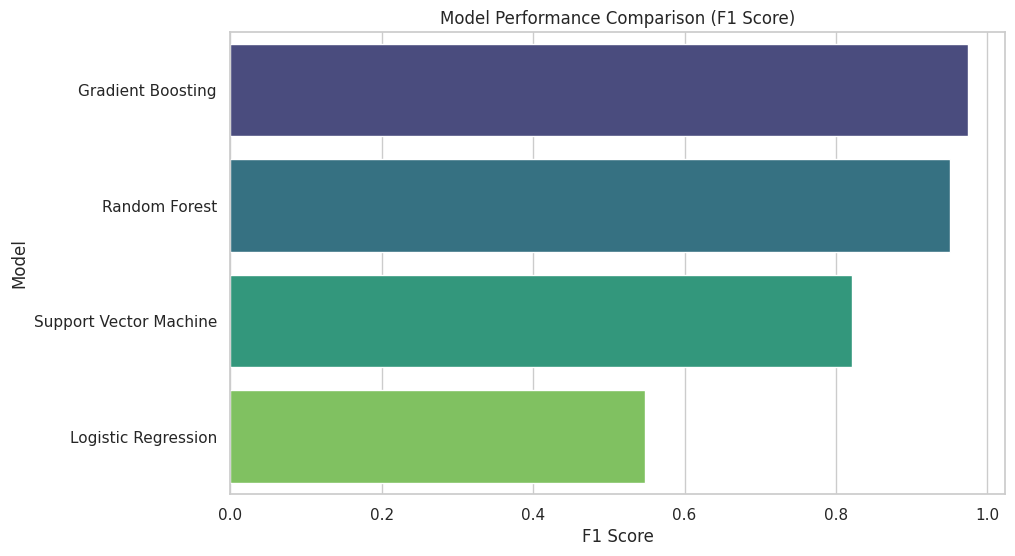

In [44]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ 1️⃣ Store predictions from your models here
# (make sure you have these variables already created)
# y_pred_lr, y_pred_svm, y_pred_rf, y_pred_gb

# ✅ 2️⃣ Create a dictionary of models and their predictions
model_predictions = {
    "Logistic Regression": y_pred_lr,
    "Support Vector Machine": y_pred_svm,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gb
}

# ✅ 3️⃣ Loop through models and calculate metrics
results = []
for name, preds in model_predictions.items():
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    results.append([name, acc, prec, rec, f1])

# ✅ 4️⃣ Create DataFrame for comparison
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
results_df = results_df.sort_values(by="F1 Score", ascending=False)

# ✅ 5️⃣ Display neatly
print("\n✅ Model Comparison Table:\n")
print(results_df.to_markdown(index=False))

# ✅ 6️⃣ (Optional) Visual comparison
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x="F1 Score", y="Model", data=results_df, palette="viridis")
plt.title("Model Performance Comparison (F1 Score)")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.show()

Checking for Overfitting

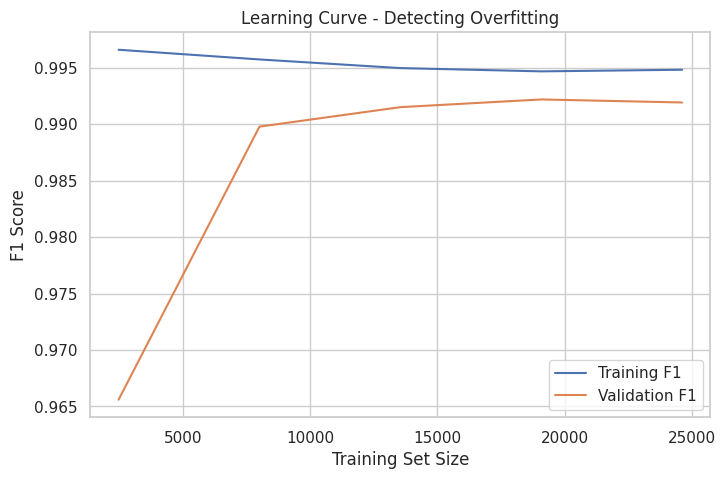

In [45]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    gb_model, X_train_scaled, y_train_res,
    cv=3, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label="Training F1")
plt.plot(train_sizes, test_mean, label="Validation F1")
plt.title("Learning Curve - Detecting Overfitting")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

In [49]:
model = gb_model
# The feature importances are for the PCA components, not the original features.
# Create names for the PCA components to match the length of feature_importances_
pca_feature_names = [f"PC_{i}" for i in range(model.feature_importances_.shape[0])]

feature_importances = pd.DataFrame({
    "Feature": pca_feature_names, # Use PCA component names
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("🔹 Top 15 Most Important Features Influencing Social Weakness (PCA Components):")
print(feature_importances.head(15).to_markdown(index=False))

🔹 Top 15 Most Important Features Influencing Social Weakness (PCA Components):
| Feature   |   Importance |
|:----------|-------------:|
| PC_6      |    0.0913179 |
| PC_2      |    0.0862113 |
| PC_9      |    0.0832701 |
| PC_3      |    0.0832242 |
| PC_4      |    0.0821396 |
| PC_7      |    0.0396145 |
| PC_43     |    0.0318953 |
| PC_38     |    0.0309467 |
| PC_37     |    0.030258  |
| PC_40     |    0.0252926 |
| PC_11     |    0.0239552 |
| PC_34     |    0.0237519 |
| PC_25     |    0.022935  |
| PC_33     |    0.0201026 |
| PC_22     |    0.0195633 |


Apply this just before pca also

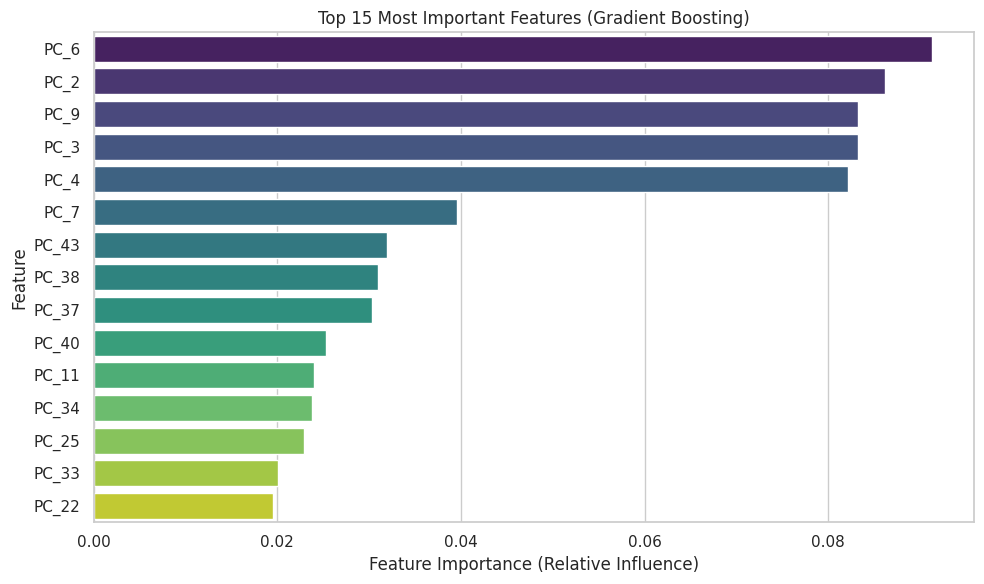

In [50]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importances.head(15),
    palette="viridis"
)
plt.title("Top 15 Most Important Features (Gradient Boosting)")
plt.xlabel("Feature Importance (Relative Influence)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

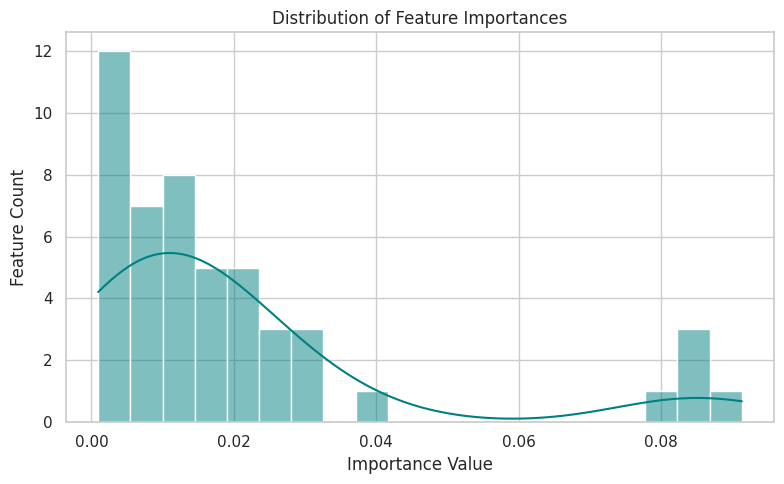

In [51]:
plt.figure(figsize=(8, 5))
sns.histplot(feature_importances["Importance"], bins=20, kde=True, color="teal")
plt.title("Distribution of Feature Importances")
plt.xlabel("Importance Value")
plt.ylabel("Feature Count")
plt.tight_layout()
plt.show()

In [2]:
#from sklearn.model_selection import RandomizedSearchCV
#import numpy as np

#param_dist = {
 #   'n_estimators': np.arange(100, 500, 50),
  #  'learning_rate': np.linspace(0.01, 0.2, 10),
   # 'max_depth': [3, 4, 5, 6, 7],
    #'subsample': [0.6, 0.8, 1.0]
#}

#random_search = RandomizedSearchCV(
  #  GradientBoostingClassifier(random_state=42),
   # param_distributions=param_dist,
    #n_iter=20,
    #scoring='f1',
    #cv=3,
    #verbose=2,
    #n_jobs=-1,
    #random_state=42
#)

#random_search.fit(X_train_scaled, y_train_res)
#print("\n✅ Best Parameters Found (Random Search):", random_search.best_params_)
#print("✅ Best F1 Score (CV):", random_search.best_score_)

#best_gb_model = random_search.best_estimator_

NameError: name 'X_train_scaled' is not defined